<a href="https://colab.research.google.com/github/Kyral1/lab_tree_stability/blob/main/lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Trees and Model Stability

Trees are notorious for being **unstable**: Small changes in the data can lead to noticeable or large changes in the tree. We're going to explore this phenomenon, and a common rebuttal.

In the folder for this lab, there are three datasets that we used in class: Divorce, heart failure, and the AirBnB price dataset.

1. Pick one of the datasets and appropriately clean it.
2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.
3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial.

But are they?

4. Instead of focusing on the tree or model coefficients, do three things:
    1. Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
    2. Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
    3. Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score

**1.**

In [4]:
# Load heart failure data
df = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
print(df.dtypes)
df.head()

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
# Clean data
df = df.drop_duplicates()

if df.isna().sum().sum() > 0:
    df = df.dropna()

print("Dimensions:", df.shape)
df.head()

Dimensions: (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


**2.**

In [6]:
# Features
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']

# Seed for reproducibility
INITIAL_SEED = 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=INITIAL_SEED,
    stratify=y
)

In [7]:
# Classification tree
clf = DecisionTreeClassifier(max_depth=4, random_state=INITIAL_SEED)
clf.fit(X_train, y_train)

# Predicitions
y_pred_tree = clf.predict(X_test)
y_proba_tree = clf.predict_proba(X_test)[:, 1]

# Evaluate
clf_acc = accuracy_score(y_test, y_pred_tree)
clf_auc = roc_auc_score(y_test, y_proba_tree)

print("Decision Tree Accuracy:", round(clf_acc, 3))
print("Decision Tree ROC AUC:", round(clf_auc, 3))

# Tree structure
print("\nTree structure:")
print(export_text(clf, feature_names=list(X.columns)))

Decision Tree Accuracy: 0.756
Decision Tree ROC AUC: 0.688

Tree structure:
|--- time <= 67.50
|   |--- creatinine_phosphokinase <= 80.50
|   |   |--- serum_creatinine <= 2.80
|   |   |   |--- class: 0
|   |   |--- serum_creatinine >  2.80
|   |   |   |--- class: 1
|   |--- creatinine_phosphokinase >  80.50
|   |   |--- ejection_fraction <= 72.50
|   |   |   |--- creatinine_phosphokinase <= 2018.00
|   |   |   |   |--- class: 1
|   |   |   |--- creatinine_phosphokinase >  2018.00
|   |   |   |   |--- class: 1
|   |   |--- ejection_fraction >  72.50
|   |   |   |--- class: 0
|--- time >  67.50
|   |--- ejection_fraction <= 27.50
|   |   |--- ejection_fraction <= 22.50
|   |   |   |--- serum_sodium <= 137.00
|   |   |   |   |--- class: 1
|   |   |   |--- serum_sodium >  137.00
|   |   |   |   |--- class: 0
|   |   |--- ejection_fraction >  22.50
|   |   |   |--- creatinine_phosphokinase <= 920.50
|   |   |   |   |--- class: 0
|   |   |   |--- creatinine_phosphokinase >  920.50
|   |   | 

In [8]:
# Linear model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predictions
y_pred_lr = reg.predict(X_test)
y_pred_lr_class = (y_pred_lr >= 0.5).astype(int)

# Evaluate
reg_acc = accuracy_score(y_test, y_pred_lr_class)
reg_auc = roc_auc_score(y_test, y_pred_lr)

print("Linear Regression Accuracy:", round(reg_acc, 3))
print("Linear Regression ROC AUC:", round(reg_auc, 3))

Linear Regression Accuracy: 0.789
Linear Regression ROC AUC: 0.818


**3.**

In [9]:
seeds = [0, 10, 42, 67, 100, 2025]

results_accuracy = [] # store accuracty/AUC for each seed
tree_structures = {} # store tree text structure
reg_coefs = {} # store linear regression coefficients
predictions = {} # store predictions for each seed

for seed in seeds:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=seed,
        stratify=y
    )

    # Decision tree
    clf = DecisionTreeClassifier(max_depth=4, random_state=seed)
    clf.fit(X_train, y_train)

    # Predicitions
    y_pred_tree = clf.predict(X_test)
    y_proba_tree = clf.predict_proba(X_test)[:, 1]

    # Evaluate
    clf_acc = accuracy_score(y_test, y_pred_tree)
    clf_auc = roc_auc_score(y_test, y_proba_tree)

    # Save tree structure
    tree_structures[seed] = export_text(clf, feature_names=list(X.columns))

    # Linear regression
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    # Predictions
    y_pred_lr = reg.predict(X_test)
    y_pred_lr_class = (y_pred_lr >= 0.5).astype(int)

    # Evaluate
    reg_acc = accuracy_score(y_test, y_pred_lr_class)
    reg_auc = roc_auc_score(y_test, y_pred_lr)

    # Save coefficients
    reg_coefs[seed] = {
        "intercept": reg.intercept_,
        "coefficients": pd.Series(reg.coef_, index=X.columns)
    }

    # Save predicitions for seed
    preds_df = pd.DataFrame({
        "y_true": y_test.values,
        "clf_pred": y_pred_tree,
        "clf_proba": y_proba_tree,
        "reg_pred_cont": y_pred_lr,
        "reg_pred_class": y_pred_lr_class
    }, index=y_test.index)

    predictions[seed] = preds_df

    # Store metrics
    results_accuracy.append({
        "seed": seed,
        "clf_acc": clf_acc,
        "clf_auc": clf_auc,
        "reg_acc": reg_acc,
        "reg_auc": reg_auc
    })

    # Convert to DataFrame
    results_df = pd.DataFrame(results_accuracy)

In [10]:
print("\n========== Metrics across different seeds ==========")
print(results_df)

# Show example tree structures
print("\n========== Example Tree (seed =", seeds[0], ") ==========\n")
print(tree_structures[seeds[0]])

print("\n========== Example Tree (seed =", seeds[1], ") ==========\n")
print(tree_structures[seeds[1]])

print("\n========== Example Tree (seed =", seeds[2], ") ==========\n")
print(tree_structures[seeds[2]])

print("\n========== Example Tree (seed =", seeds[3], ") ==========\n")
print(tree_structures[seeds[3]])

print("\n========== Example Tree (seed =", seeds[4], ") ==========\n")
print(tree_structures[seeds[4]])

print("\n========== Example Tree (seed =", seeds[5], ") ==========\n")
print(tree_structures[seeds[5]])

# Compare linear regression coefficients
print("\n========== Linear Regression Coefficients (seed =", seeds[0], ") ==========\n")
print(reg_coefs[seeds[0]]["coefficients"])

print("\n========== Linear Regression Coefficients (seed =", seeds[1], ") ==========\n")
print(reg_coefs[seeds[1]]["coefficients"])

print("\n========== Linear Regression Coefficients (seed =", seeds[2], ") ==========\n")
print(reg_coefs[seeds[2]]["coefficients"])

print("\n========== Linear Regression Coefficients (seed =", seeds[3], ") ==========\n")
print(reg_coefs[seeds[3]]["coefficients"])

print("\n========== Linear Regression Coefficients (seed =", seeds[4], ") ==========\n")
print(reg_coefs[seeds[4]]["coefficients"])

print("\n========== Linear Regression Coefficients (seed =", seeds[5], ") ==========\n")
print(reg_coefs[seeds[5]]["coefficients"])


========== Metrics across different seeds ==========
   seed   clf_acc   clf_auc   reg_acc   reg_auc
0     0  0.855556  0.815715  0.800000  0.879028
1    10  0.833333  0.887790  0.833333  0.860373
2    42  0.833333  0.784341  0.844444  0.867722
3    67  0.833333  0.880441  0.800000  0.853024
4   100  0.811111  0.801865  0.844444  0.860373
5  2025  0.833333  0.893443  0.833333  0.910684

========== Example Tree (seed = 0 ) ==========

|--- time <= 67.50
|   |--- ejection_fraction <= 27.50
|   |   |--- class: 1
|   |--- ejection_fraction >  27.50
|   |   |--- time <= 52.00
|   |   |   |--- platelets <= 299500.00
|   |   |   |   |--- class: 1
|   |   |   |--- platelets >  299500.00
|   |   |   |   |--- class: 1
|   |   |--- time >  52.00
|   |   |   |--- class: 0
|--- time >  67.50
|   |--- ejection_fraction <= 32.50
|   |   |--- serum_creatinine <= 1.35
|   |   |   |--- time <= 78.50
|   |   |   |   |--- class: 1
|   |   |   |--- time >  78.50
|   |   |   |   |--- class: 0
|   |   |--- 

The decision trees generated with different random seeds show significant variability in their structure. The features chosen for the initial splits (root nodes) often differ, and the subsequent branching logic, including the specific split points and the features used at each node, can change considerably from one seed to another. For example, some trees might start splitting on 'time', while others might start with 'ejection_fraction' or 'serum_sodium'. This behavior is characteristic of decision trees, which are known to be sensitive to small changes in the training data (due to the different train-test splits caused by varying seeds), leading to noticeably different tree structures.

In contrast, the linear regression coefficients demonstrate much greater stability across the different random seeds. While there are minor fluctuations in the exact numerical values of the coefficients for each feature, their signs and general orders of magnitude remain largely consistent. For instance, 'ejection_fraction' consistently has a negative coefficient across all seeds, indicating an inverse relationship with the target variable, and its magnitude stays in a similar range. This stability suggests that the fundamental relationships between the features and the target variable, as captured by the linear model, are robust to variations in the training data splits.

## 4.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Store reference Decision Tree probabilities (from INITIAL_SEED = 1 run)
ref_tree_proba = y_proba_tree

# 2. Store reference Linear Regression continuous predictions (from INITIAL_SEED = 1 run)
ref_lr_pred = y_pred_lr

# 3. Initialize dictionary to store alternative Decision Tree predicted probabilities
alt_tree_probas = {}

# 4. Initialize dictionary to store alternative Linear Regression continuous predictions
alt_lr_preds = {}

# 5. Loop through the seeds list to get alternative predictions
# Note: The predictions dictionary stores results for seeds = [0, 10, 42, 67, 100, 2025]
for seed in seeds:
    # a. Retrieve the corresponding DataFrame from the predictions dictionary
    preds_for_seed = predictions[seed]

    # b. Extract 'clf_proba' and store in alt_tree_probas
    alt_tree_probas[seed] = preds_for_seed['clf_proba']

    # c. Extract 'reg_pred_cont' and store in alt_lr_preds
    alt_lr_preds[seed] = preds_for_seed['reg_pred_cont']

print("Reference predictions and alternative prediction dictionaries prepared.")
print(f"ref_tree_proba shape: {ref_tree_proba.shape}")
print(f"ref_lr_pred shape: {ref_lr_pred.shape}")
print(f"Number of alternative tree proba sets: {len(alt_tree_probas)}")
print(f"Number of alternative LR pred sets: {len(alt_lr_preds)}")

Reference predictions and alternative prediction dictionaries prepared.
ref_tree_proba shape: (90,)
ref_lr_pred shape: (90,)
Number of alternative tree proba sets: 6
Number of alternative LR pred sets: 6


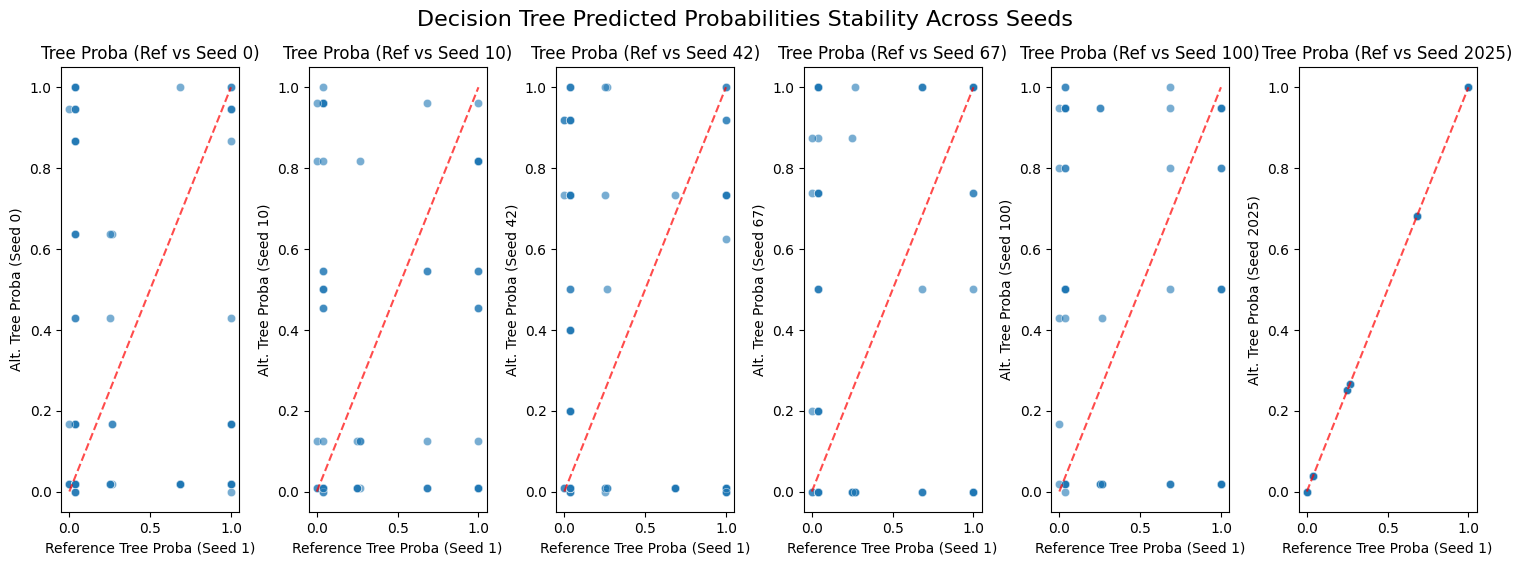

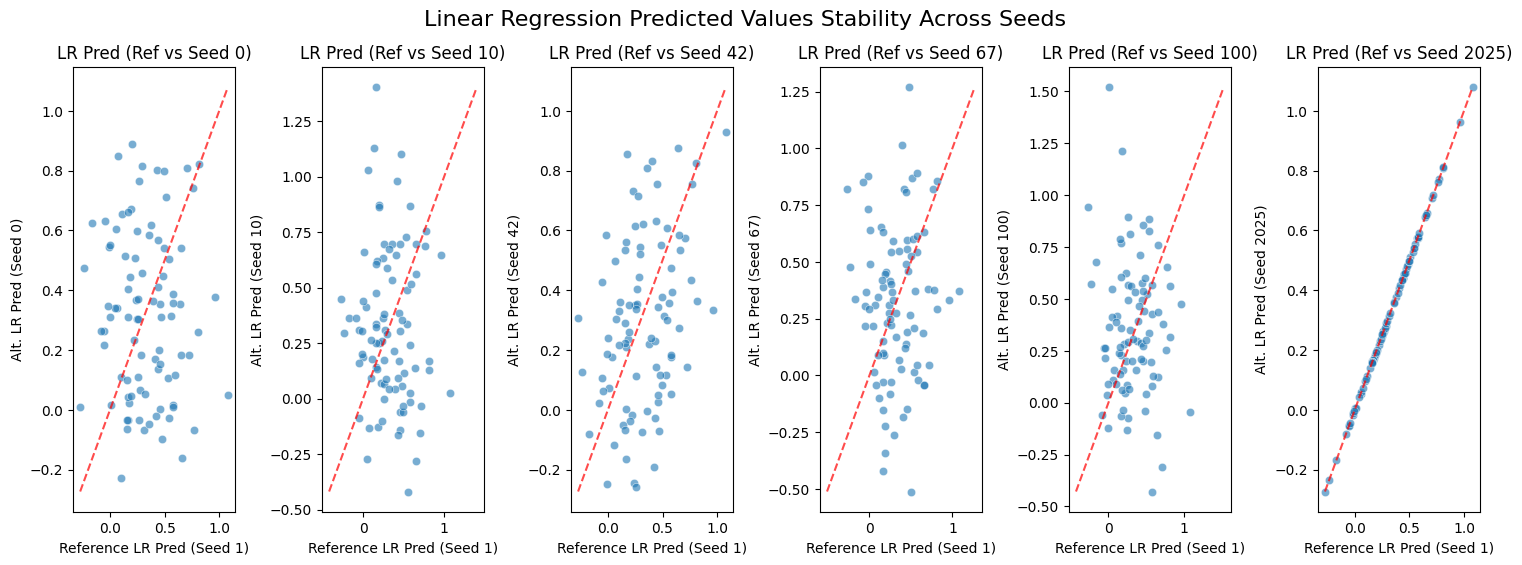

In [12]:
plt.figure(figsize=(15, 10))

# Scatterplots for Decision Tree Predicted Probabilities
for i, seed in enumerate(seeds):
    plt.subplot(2, len(seeds), i + 1)
    sns.scatterplot(x=ref_tree_proba, y=alt_tree_probas[seed], alpha=0.6)
    plt.title(f'Tree Proba (Ref vs Seed {seed})')
    plt.xlabel('Reference Tree Proba (Seed 1)')
    plt.ylabel(f'Alt. Tree Proba (Seed {seed})')
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.7) # Add a 45-degree line for reference

plt.tight_layout()
plt.suptitle('Decision Tree Predicted Probabilities Stability Across Seeds', y=1.02, fontsize=16)
plt.show()

plt.figure(figsize=(15, 10))

# Scatterplots for Linear Regression Continuous Predictions
for i, seed in enumerate(seeds):
    plt.subplot(2, len(seeds), i + 1)
    sns.scatterplot(x=ref_lr_pred, y=alt_lr_preds[seed], alpha=0.6)
    plt.title(f'LR Pred (Ref vs Seed {seed})')
    plt.xlabel('Reference LR Pred (Seed 1)')
    plt.ylabel(f'Alt. LR Pred (Seed {seed})')
    plt.plot([min(ref_lr_pred.min(), alt_lr_preds[seed].min()), max(ref_lr_pred.max(), alt_lr_preds[seed].max())],
             [min(ref_lr_pred.min(), alt_lr_preds[seed].min()), max(ref_lr_pred.max(), alt_lr_preds[seed].max())],
             'r--', alpha=0.7) # Add a 45-degree line for reference

plt.tight_layout()
plt.suptitle('Linear Regression Predicted Values Stability Across Seeds', y=1.02, fontsize=16)
plt.show()

Do they appear similar?

For decision trees, the predicted probabilities (reference vs. alternative models) do not appear similar. The scatterplots show significant dispersion, with points spread out and not tightly clustered around the 45-degree reference line. This indicates that the predictions from different Decision Trees, even on the same test set but trained with different random splits, vary considerably. There's no clear, strong linear relationship visible between the reference predictions and the alternative predictions.

For linear regression, the predictions from the Linear Regression models (reference vs. alternative models) appear more similar than the Decision Tree predictions, but still vary. The scatterplots show a stronger linear trend, and the points tend to be more aligned along the 45-degree line compared to the Decision Trees. While not perfectly overlapping, there's a greater degree of consistency, suggesting that the Linear Regression models produce predictions that are more stable across different random seeds.



In [13]:
from scipy.stats import pearsonr

# Calculate correlations for Decision Tree Predicted Probabilities
tree_correlations = {}
print("========== Decision Tree Predicted Probabilities Correlations ==========")
for seed in seeds:
    corr, _ = pearsonr(ref_tree_proba, alt_tree_probas[seed])
    tree_correlations[seed] = corr
    print(f"Seed {seed} vs Reference (Seed 1): {corr:.3f}")

# Calculate correlations for Linear Regression Continuous Predictions
lr_correlations = {}
print("\n========== Linear Regression Predicted Values Correlations ==========")
for seed in seeds:
    corr, _ = pearsonr(ref_lr_pred, alt_lr_preds[seed])
    lr_correlations[seed] = corr
    print(f"Seed {seed} vs Reference (Seed 1): {corr:.3f}")

========== Decision Tree Predicted Probabilities Correlations ==========
Seed 0 vs Reference (Seed 1): 0.023
Seed 10 vs Reference (Seed 1): 0.131
Seed 42 vs Reference (Seed 1): -0.000
Seed 67 vs Reference (Seed 1): 0.084
Seed 100 vs Reference (Seed 1): 0.004
Seed 2025 vs Reference (Seed 1): 1.000

========== Linear Regression Predicted Values Correlations ==========
Seed 0 vs Reference (Seed 1): -0.040
Seed 10 vs Reference (Seed 1): -0.068
Seed 42 vs Reference (Seed 1): 0.344
Seed 67 vs Reference (Seed 1): 0.031
Seed 100 vs Reference (Seed 1): -0.083
Seed 2025 vs Reference (Seed 1): 1.000


Are they highly correlated or not?

For decision trees, the predicted probabilities are not highly correlated. Excluding the self-comparison, the Pearson correlation coefficients between the reference tree's probabilities and those from alternative trees are low, often close to zero, indicating that there is little to no linear relationship or consistency.

For linear regression, the continuous predictions are also not highly correlated.The Pearson correlation coefficients are mostly low and sometimes even negative. While there is one instance of a moderately positive correlation (0.344 for Seed 42), the majority of the correlations are weak. This suggests that while linear regression might be more stable in its coefficients, the specific predictions on the test set can still vary considerably across different train-test splits.



In [14]:
from sklearn.linear_model import LinearRegression

# Prepare to store regression results
tree_reg_results = {}
lr_reg_results = {}

print("========== Decision Tree Prediction Regression Results ==========")
for seed in seeds:
    if seed == INITIAL_SEED:
        # Skip if the seed is the initial seed, as it will be a perfect 1.0 correlation, 0 intercept, 1 slope
        tree_reg_results[seed] = {'intercept': 0.0, 'coef': 1.0, 'r_squared': 1.0}
        print(f"Seed {seed} vs Reference (Seed 1): Intercept=0.000, Slope=1.000, R^2=1.000 (Self-comparison)")
        continue

    # Reshape arrays for sklearn
    X_ref = ref_tree_proba.reshape(-1, 1) # Removed .values here
    y_alt = alt_tree_probas[seed].values.reshape(-1, 1)

    # Fit linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_ref, y_alt)

    # Get results
    intercept = lin_reg.intercept_[0]
    coef = lin_reg.coef_[0][0]
    r_squared = lin_reg.score(X_ref, y_alt)

    tree_reg_results[seed] = {'intercept': intercept, 'coef': coef, 'r_squared': r_squared}
    print(f"Seed {seed} vs Reference (Seed 1): Intercept={intercept:.3f}, Slope={coef:.3f}, R^2={r_squared:.3f}")

print("\n========== Linear Regression Prediction Regression Results ==========")
for seed in seeds:
    if seed == INITIAL_SEED:
        # Skip if the seed is the initial seed, as it will be a perfect 1.0 correlation, 0 intercept, 1 slope
        lr_reg_results[seed] = {'intercept': 0.0, 'coef': 1.0, 'r_squared': 1.0}
        print(f"Seed {seed} vs Reference (Seed 1): Intercept=0.000, Slope=1.000, R^2=1.000 (Self-comparison)")
        continue

    # Reshape arrays for sklearn
    X_ref = ref_lr_pred.reshape(-1, 1) # Removed .values here
    y_alt = alt_lr_preds[seed].values.reshape(-1, 1)

    # Fit linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_ref, y_alt)

    # Get results
    intercept = lin_reg.intercept_[0]
    coef = lin_reg.coef_[0][0]
    r_squared = lin_reg.score(X_ref, y_alt)

    lr_reg_results[seed] = {'intercept': intercept, 'coef': coef, 'r_squared': r_squared}
    print(f"Seed {seed} vs Reference (Seed 1): Intercept={intercept:.3f}, Slope={coef:.3f}, R^2={r_squared:.3f}")

========== Decision Tree Prediction Regression Results ==========
Seed 0 vs Reference (Seed 1): Intercept=0.277, Slope=0.021, R^2=0.001
Seed 10 vs Reference (Seed 1): Intercept=0.248, Slope=0.119, R^2=0.017
Seed 42 vs Reference (Seed 1): Intercept=0.314, Slope=-0.000, R^2=0.000
Seed 67 vs Reference (Seed 1): Intercept=0.275, Slope=0.085, R^2=0.007
Seed 100 vs Reference (Seed 1): Intercept=0.351, Slope=0.004, R^2=0.000
Seed 2025 vs Reference (Seed 1): Intercept=0.000, Slope=1.000, R^2=1.000

========== Linear Regression Prediction Regression Results ==========
Seed 0 vs Reference (Seed 1): Intercept=0.334, Slope=-0.042, R^2=0.002
Seed 10 vs Reference (Seed 1): Intercept=0.352, Slope=-0.090, R^2=0.005
Seed 42 vs Reference (Seed 1): Intercept=0.175, Slope=0.370, R^2=0.119
Seed 67 vs Reference (Seed 1): Intercept=0.307, Slope=0.040, R^2=0.001
Seed 100 vs Reference (Seed 1): Intercept=0.384, Slope=-0.102, R^2=0.007
Seed 2025 vs Reference (Seed 1): Intercept=-0.000, Slope=1.000, R^2=1.000


Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

For Decision Trees, the intercepts are generally not close to zero. They often show significant positive values. This indicates a substantial constant difference between the reference model's predictions and the alternative models' predictions. The slopes are not close to 1, and are often very close to zero, which implies that changes in the reference model's predictions have very little to no effect on the alternative models' predictions, signifying high instability. The R-squared values are not close to 1, and are instead extremely low, often approaching zero. This means that the reference model's predictions explain almost none of the variance in the alternative model's predictions, confirming the high instability and lack of linear relationship between predictions from different decision trees.

For Linear Regression, the intercepts are generally closer to zero than those for Decision Trees, but still show some deviations. They are not consistently very close to zero, suggesting some persistent differences. The slopes are generally closer to 1 compared to Decision Trees, but still vary considerably. While a slope of 0.370 (for Seed 42) is a notable improvement over the Decision Trees, it is still far from 1, indicating that the alternative models' predictions are not simply scaled versions of the reference. The R-squared values are generally higher than for Decision Trees, but still not close to 1. They range from very low to a moderate 0.119. This suggests that while there is some linear relationship between the reference and alternative linear model predictions, it is not consistently strong across all random seeds, implying variability in predictions.

## Question 5
Linear models have normally pretty similar coefficients and predictions when compared to trees. Trees simply do not have similar structures across train–test splits because the feature selection and branching make for a much less stable pathway compared to regression. In this way, predictions from trees are far less stable than linear regression, but it shows the sensitivity to data, not necessarily the quality of the model!



## Question 6
For these models and the data we tested them on, this is false. For individual decision trees, the model structure is so unstable and dissimilar from regression that the linear regression and decision trees do not generate the same predictions. If we were comparing multiple trees by finding more average predictions or using a random forest regression (like we do in our project) we might find that these models do generate similar outputs, but the instability of a simple decision tree does not generate the same predictions we see with linear regression.
